Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

1. First, load the dataset.

2. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

3. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

4. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

5. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings
from scipy.stats.stats import ttest_ind
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from scipy.stats import zscore

# warnings.filterwarnings('ignore')

## 1. First, load the dataset.

In [28]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [29]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## 2. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [30]:
# demonstrated, but not necessary if second step reveals all inputs are numbers

# print all values that cannot be converted to float
# for col in fill_list:
#     print("These are the problematic values for the variable: {}".format(col))
#     for value in df2[col]:
#         try:
#             float(value)
#         except:
#             print(value)

In [31]:
# check for erroneous inputs
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [32]:
# notice there are unnecessary spaces in some column titles & some capitalization inconsistencies
# fix these
df = df.rename(columns={"infant deaths": "Infant deaths",
                        "percentage expenditure": "Percentage expenditure",
                        "under-five deaths ": "Under-five deaths",
                        " BMI ": "BMI", 
                        " HIV/AIDS": "HIV/AIDS", 
                        " thinness  1-19 years": "Thinness 1-19 years", 
                        " thinness 5-9 years": "Thinness 5-9 years",
                        "Life expectancy ": "Life expectancy",
                        "Diphtheria ": "Diphtheria",
                        "Measles ": "Measles"
                       })
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [33]:
# check for null values
df.isnull().sum() / df.isnull().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
Infant deaths                      0.000000
Alcohol                            0.066031
Percentage expenditure             0.000000
Hepatitis B                        0.188223
Measles                            0.000000
BMI                                0.011572
Under-five deaths                  0.000000
Polio                              0.006467
Total expenditure                  0.076923
Diphtheria                         0.006467
HIV/AIDS                           0.000000
GDP                                0.152485
Population                         0.221920
Thinness 1-19 years                0.011572
Thinness 5-9 years                 0.011572
Income composition of resources    0.056841
Schooling                          0.055480
dtype: float64

There seems to be missing values in quite a few continuous variable categories. Since these values differ significantly from country to country, I believe the best method of replacement would be to use the average value of the variable in its respective country.

In [34]:
df2 = df.copy()

# variables with missing values
fill_list = ["Life expectancy", "Adult Mortality", "Alcohol", 
             "Hepatitis B", "BMI", "Polio", 
             "Total expenditure", "Diphtheria", "GDP", 
             "Population", "Thinness 1-19 years", "Thinness 5-9 years", 
             "Income composition of resources", "Schooling"
            ]

countries = df2["Country"].unique()

for col in fill_list:
    for country in countries:
        df2.loc[df2["Country"] == country, col] = df2.loc[df2["Country"] == country, col].fillna(df2[df2["Country"] == country][col].mean())
        
# NOTE: recieved key errors here. realized there were other erroneous inputs in title names. 
# for example, an extra space after "Life expectancy ". Went back to earlier step to fix these

In [35]:
# veryfy that values were filled
df2.isnull().sum() / df2.isnull().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
Infant deaths                      0.000000
Alcohol                            0.005786
Percentage expenditure             0.000000
Hepatitis B                        0.049013
Measles                            0.000000
BMI                                0.011572
Under-five deaths                  0.000000
Polio                              0.000000
Total expenditure                  0.010892
Diphtheria                         0.000000
HIV/AIDS                           0.000000
GDP                                0.137849
Population                         0.220558
Thinness 1-19 years                0.011572
Thinness 5-9 years                 0.011572
Income composition of resources    0.056841
Schooling                          0.055480
dtype: float64

In [39]:
# determine whether it's better to just remove countries (rows) without values if there is an insignificant amount
#np.count_nonzero(df2.isnull())

# find # of missing rows
df.shape[0] - df.dropna().shape[0]

1289

1289 rows missing data out of 2938 total. Each country has 15 rows(years) of data. 1289/15 = 86 countries out of 2938/15 = 195 total countries have missing data. 86/195 = 44% of the data.

In [13]:
# find # of missing 
##df2.apply(lambda x: x.count(), axis=1)

In [40]:
# remove rows with missing data
#df2 = df2.dropna()

In [41]:
# some values were filled, but not all. what could be the problem?
# Ah! The reason for this could be that entire countries have no data in these fields, so there is nothing to average.
# let's try a different fill method for these remaining averages.
# while not the best method in this scenario, I'm going to replace these values with the averages per column, until I think of a better way

#for col in fill_list:
    #df2.loc[:, col] = df2.loc[:, col].fillna(df2.loc[:, col].mean())

In [42]:
df2.isnull().sum() / df2.isnull().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
Infant deaths                      0.000000
Alcohol                            0.005786
Percentage expenditure             0.000000
Hepatitis B                        0.049013
Measles                            0.000000
BMI                                0.011572
Under-five deaths                  0.000000
Polio                              0.000000
Total expenditure                  0.010892
Diphtheria                         0.000000
HIV/AIDS                           0.000000
GDP                                0.137849
Population                         0.220558
Thinness 1-19 years                0.011572
Thinness 5-9 years                 0.011572
Income composition of resources    0.056841
Schooling                          0.055480
dtype: float64

In [13]:
# good! all vals are filled to the best of my ability
# let's check for outliers now

# z score method
for col in fill_list:
    z_scores = zscore(df2[col])
    for threshold in range(1,5):
        print("The score threshold is: {}".format(threshold))
        print("The indices of the outliers for {}:".format(col))
        print(np.where(z_scores > threshold))
        print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers for Life expectancy:
(array([ 113,  114,  115,  116,  117,  118,  119,  120,  121,  122,  123,
        124,  125,  126,  127,  128,  129,  130,  131,  132,  133,  134,
        135,  136,  137,  138,  139,  140,  141,  241,  242,  243,  244,
        245,  246,  247,  248,  249,  250,  251,  252,  496,  497,  498,
        499,  500,  501,  502,  503,  504,  505,  506,  507,  508,  509,
        510,  511,  544,  545,  546,  547,  548,  549,  550,  551,  552,
        553,  625,  626,  627,  628,  629,  631,  632,  633,  657,  658,
        661,  673,  674,  675,  676,  677,  678,  679,  680,  681,  682,
        689,  737,  738,  739,  740,  741,  742,  743,  744,  802,  804,
        915,  916,  917,  918,  919,  920,  921,  922,  923,  924,  925,
        931,  932,  933,  934,  935,  936,  937,  938,  939,  940,  941,
        942,  943,  944,  945,  946,  995,  996,  997,  998,  999, 1000,
       1001, 1002, 1003, 1004, 1005, 1006, 1027,

In [14]:
# tukey's method

# NumPy's percentile() method returns the 
# values of the given percentiles. In our case,
# we give 75 and 25 as parameters which corresponds 
# to the third and the first quartile.

for col in fill_list:
    q75, q25 = np.percentile(df2[col], [75, 25])
    iqr = q75 - q25
    for threshold in np.arange(1,5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers in {} is: {}".format(col,
            len((np.where((df2[col] > max_val) 
                          | (df2[col] < min_val))[0]))
        ))

The score threshold is: 1.0
Number of outliers in Life expectancy is: 148
The score threshold is: 1.5
Number of outliers in Life expectancy is: 17
The score threshold is: 2.0
Number of outliers in Life expectancy is: 1
The score threshold is: 2.5
Number of outliers in Life expectancy is: 0
The score threshold is: 3.0
Number of outliers in Life expectancy is: 0
The score threshold is: 3.5
Number of outliers in Life expectancy is: 0
The score threshold is: 4.0
Number of outliers in Life expectancy is: 0
The score threshold is: 4.5
Number of outliers in Life expectancy is: 0
The score threshold is: 1.0
Number of outliers in Adult Mortality is: 183
The score threshold is: 1.5
Number of outliers in Adult Mortality is: 86
The score threshold is: 2.0
Number of outliers in Adult Mortality is: 41
The score threshold is: 2.5
Number of outliers in Adult Mortality is: 22
The score threshold is: 3.0
Number of outliers in Adult Mortality is: 5
The score threshold is: 3.5
Number of outliers in Adult 

In [43]:
# so yes, we can see that there are outliers
# now, let's treat them

# win
df3 = df2.copy()
# sqrt
df4 = df2.copy()
# log
df5 = df2.copy()

# update fill_list to include all continuous variables
fill_list = ["Life expectancy", "Adult Mortality", "Infant deaths",
             "Alcohol", "Percentage expenditure", "Hepatitis B", 
             "Measles", "BMI", "Under-five deaths",
             "Polio", "Total expenditure", "Diphtheria",
             "GDP", "Population", "Thinness 1-19 years", 
             "Thinness 5-9 years", "Income composition of resources", 
             "Schooling"
            ]

# winsorize
for col in fill_list:
    df3.loc[:, col] = winsorize(df3.loc[:, col], (0, 0.331)) # what percentile to use? this eliminated all outliers
    
# square root
for col in fill_list:
    df4.loc[:, col] = np.sqrt(df4.loc[:, col])

# log
for col in fill_list:
    df5.loc[:, col] = np.log1p(df5.loc[:, col])

In [16]:
#plt.boxplot(df3["Adult Mortality"])

In [41]:
for col in fill_list:
    z_scores = zscore(df3[col])
    for threshold in range(1,5):
        print("The score threshold is: {}".format(threshold))
        print("The indices of the outliers for {}:".format(col))
        print(np.where(z_scores > threshold))
        print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers for Life expectancy:
(array([], dtype=int32),)
Number of outliers is: 0
The score threshold is: 2
The indices of the outliers for Life expectancy:
(array([], dtype=int32),)
Number of outliers is: 0
The score threshold is: 3
The indices of the outliers for Life expectancy:
(array([], dtype=int32),)
Number of outliers is: 0
The score threshold is: 4
The indices of the outliers for Life expectancy:
(array([], dtype=int32),)
Number of outliers is: 0
The score threshold is: 1
The indices of the outliers for Adult Mortality:
(array([], dtype=int32),)
Number of outliers is: 0
The score threshold is: 2
The indices of the outliers for Adult Mortality:
(array([], dtype=int32),)
Number of outliers is: 0
The score threshold is: 3
The indices of the outliers for Adult Mortality:
(array([], dtype=int32),)
Number of outliers is: 0
The score threshold is: 4
The indices of the outliers for Adult Mortality:
(array([], dtype=int32),)
Number of outlier

In [18]:
for col in fill_list:
    q75, q25 = np.percentile(df3[col], [75, 25])
    iqr = q75 - q25
    for threshold in np.arange(1,5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers in {} is: {}".format(col,
            len((np.where((df3[col] > max_val) 
                          | (df3[col] < min_val))[0]))
        ))

The score threshold is: 1.0
Number of outliers in Life expectancy is: 174
The score threshold is: 1.5
Number of outliers in Life expectancy is: 44
The score threshold is: 2.0
Number of outliers in Life expectancy is: 2
The score threshold is: 2.5
Number of outliers in Life expectancy is: 0
The score threshold is: 3.0
Number of outliers in Life expectancy is: 0
The score threshold is: 3.5
Number of outliers in Life expectancy is: 0
The score threshold is: 4.0
Number of outliers in Life expectancy is: 0
The score threshold is: 4.5
Number of outliers in Life expectancy is: 0
The score threshold is: 1.0
Number of outliers in Adult Mortality is: 0
The score threshold is: 1.5
Number of outliers in Adult Mortality is: 0
The score threshold is: 2.0
Number of outliers in Adult Mortality is: 0
The score threshold is: 2.5
Number of outliers in Adult Mortality is: 0
The score threshold is: 3.0
Number of outliers in Adult Mortality is: 0
The score threshold is: 3.5
Number of outliers in Adult Morta

## 3. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In [19]:
df3.describe()

,Year,Life expectancy,Adult Mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis B,Measles,BMI,Under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
count,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2.128000e+03,2128.000000,2128.000000,2128.000000,2128.000000
mean,2007.500000,66.775423,137.882519,6.429041,3.357263,125.964756,76.388878,68.206297,34.442810,8.192669,79.744938,5.342493,79.894938,2.173637,1751.525600,2.044885e+06,3.768938,3.796053,0.579078,11.043656
std,4.610856,8.120339,71.344910,6.015076,2.402369,108.436633,24.585886,75.489496,17.204163,7.726672,23.600808,1.537724,23.625261,5.827273,1387.875334,1.804495e+06,2.307435,2.309943,0.174942,2.454333
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,1.400000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2003.750000,62.000000,76.000000,1.000000,0.827500,19.883256,68.000000,0.000000,18.400000,1.000000,75.000000,4.367500,76.000000,0.100000,395.911290,1.989615e+05,1.600000,1.600000,0.476750,9.800000
50%,2007.500000,69.950000,152.000000,4.000000,3.735000,83.677991,87.000000,20.000000,38.850000,4.000000,91.000000,5.800000,91.000000,0.100000,1351.177885,1.433672e+06,3.400000,3.400000,0.649500,11.900000
75%,2011.250000,73.600000,211.000000,14.000000,5.990000,259.157238,94.000000,167.000000,52.100000,18.000000,95.000000,6.750000,95.000000,1.300000,3439.597513,4.267558e+06,6.400000,6.400000,0.718000,13.100000
max,2015.000000,73.600000,211.000000,14.000000,5.990000,259.157238,94.000000,167.000000,52.100000,18.000000,95.000000,6.750000,95.000000,50.600000,3439.597513,4.267558e+06,6.400000,6.400000,0.718000,13.100000


In [20]:
#df5.to_excel("output.xlsx")

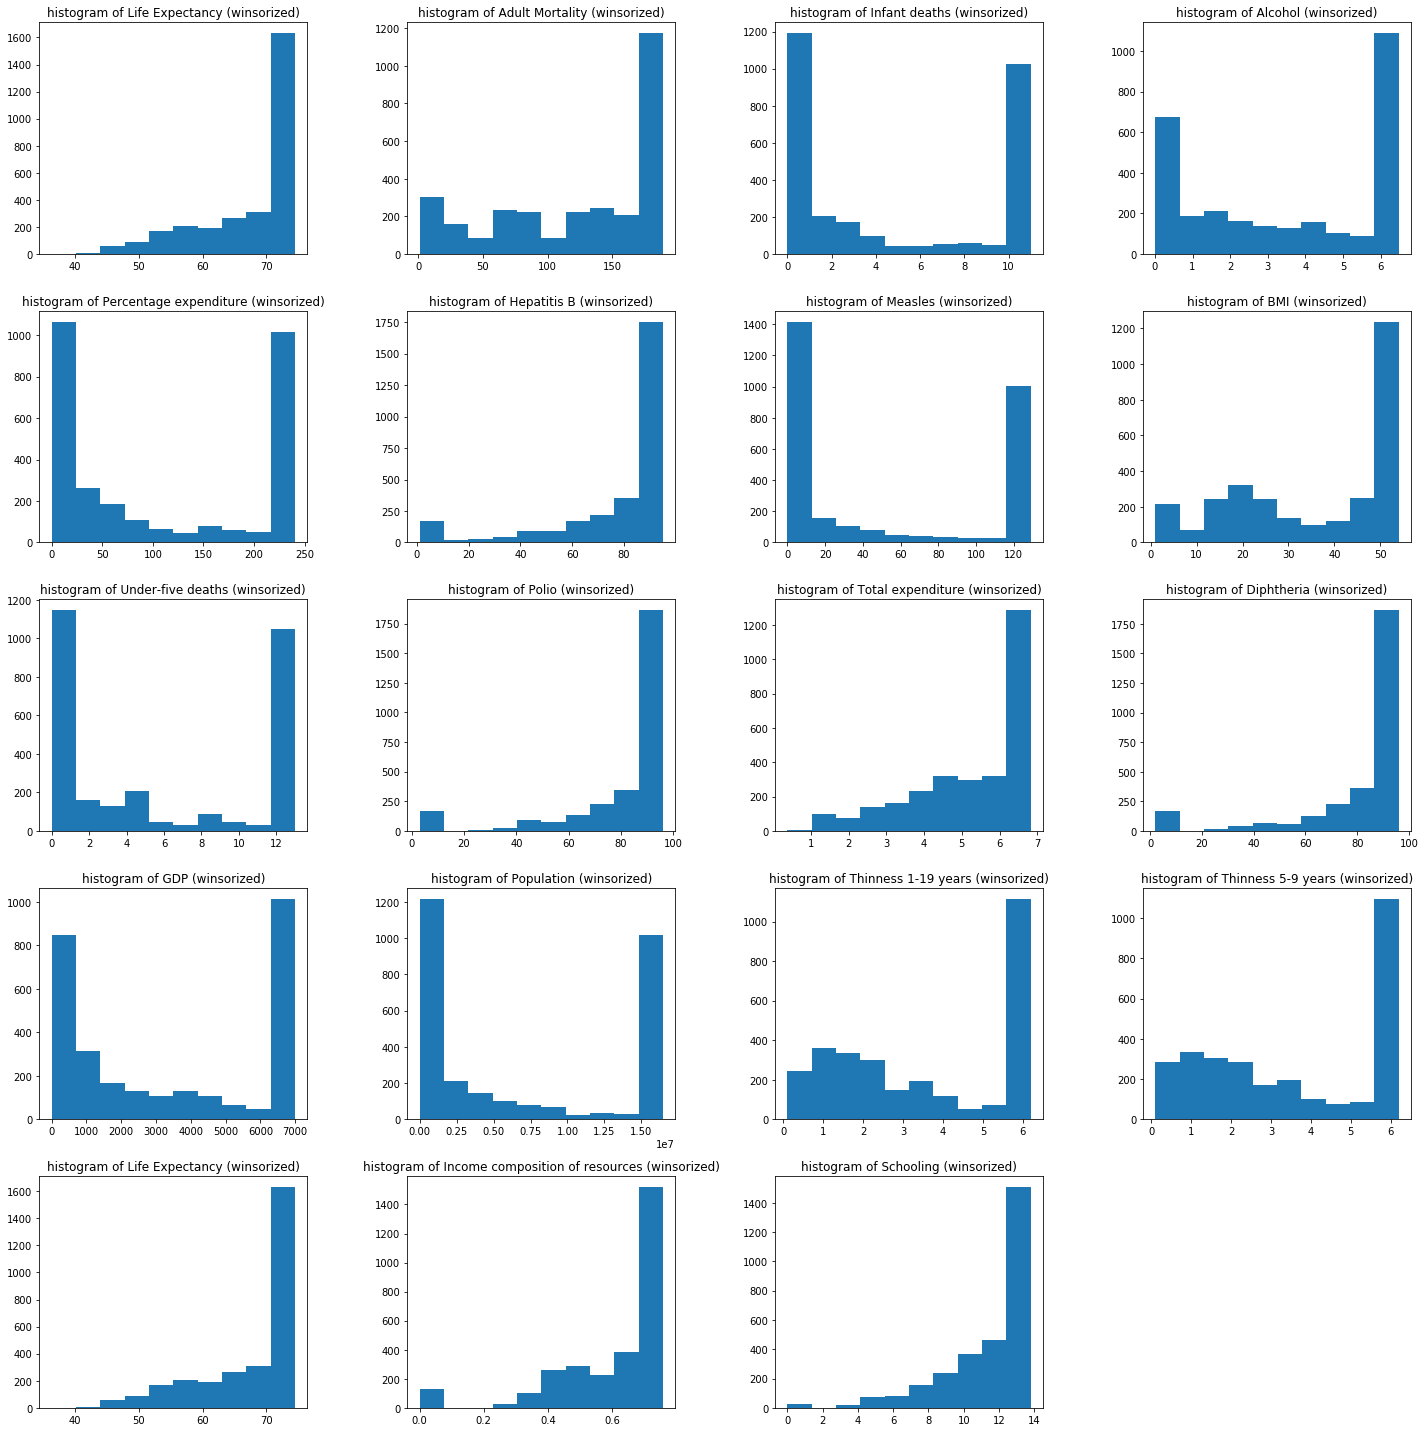

In [44]:
# winsorized distributions

# update fill_list to include all continuous variables
fill_list = ["Life expectancy", "Adult Mortality", "Infant deaths",
             "Alcohol", "Percentage expenditure", "Hepatitis B", 
             "Measles", "BMI", "Under-five deaths",
             "Polio", "Total expenditure", "Diphtheria",
             "GDP", "Population", "Thinness 1-19 years", 
             "Thinness 5-9 years", "Income composition of resources", 
             "Schooling"
            ]

# 19 continuous vars
# 5 rows, 4 columns

# plot histograms of all continuous variables 
plt.figure(figsize=(20,20))

plt.subplot(541)
plt.hist(df3["Life expectancy"])
plt.title("histogram of {} (winsorized)".format("Life Expectancy"))

plt.subplot(542)
plt.hist(df3["Adult Mortality"])
plt.title("histogram of {} (winsorized)".format("Adult Mortality"))

plt.subplot(543)
plt.hist(df3["Infant deaths"])
plt.title("histogram of {} (winsorized)".format("Infant deaths"))

plt.subplot(544)
plt.hist(df3["Alcohol"])
plt.title("histogram of {} (winsorized)".format("Alcohol"))

plt.subplot(545)
plt.hist(df3["Percentage expenditure"])
plt.title("histogram of {} (winsorized)".format("Percentage expenditure"))

plt.subplot(546)
plt.hist(df3["Hepatitis B"])
plt.title("histogram of {} (winsorized)".format("Hepatitis B"))

plt.subplot(547)
plt.hist(df3["Measles"])
plt.title("histogram of {} (winsorized)".format("Measles"))

plt.subplot(548)
plt.hist(df3["BMI"])
plt.title("histogram of {} (winsorized)".format("BMI"))

plt.subplot(549)
plt.hist(df3["Under-five deaths"])
plt.title("histogram of {} (winsorized)".format("Under-five deaths"))

plt.subplot(5,4,10)
plt.hist(df3["Polio"])
plt.title("histogram of {} (winsorized)".format("Polio"))

plt.subplot(5,4,11)
plt.hist(df3["Total expenditure"])
plt.title("histogram of {} (winsorized)".format("Total expenditure"))

plt.subplot(5,4,12)
plt.hist(df3["Diphtheria"])
plt.title("histogram of {} (winsorized)".format("Diphtheria"))

plt.subplot(5,4,13)
plt.hist(df3["GDP"])
plt.title("histogram of {} (winsorized)".format("GDP"))

plt.subplot(5,4,14)
plt.hist(df3["Population"])
plt.title("histogram of {} (winsorized)".format("Population"))

plt.subplot(5,4,15)
plt.hist(df3["Thinness 1-19 years"])
plt.title("histogram of {} (winsorized)".format("Thinness 1-19 years"))

plt.subplot(5,4,16)
plt.hist(df3["Thinness 5-9 years"])
plt.title("histogram of {} (winsorized)".format("Thinness 5-9 years"))

plt.subplot(5,4,17)
plt.hist(df3["Life expectancy"])
plt.title("histogram of {} (winsorized)".format("Life Expectancy"))

plt.subplot(5,4,18)
plt.hist(df3["Income composition of resources"])
plt.title("histogram of {} (winsorized)".format("Income composition of resources"))

plt.subplot(5,4,19)
plt.hist(df3["Schooling"])
plt.title("histogram of {} (winsorized)".format("Schooling"))

plt.tight_layout()
plt.show()

c:\users\conno\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\conno\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


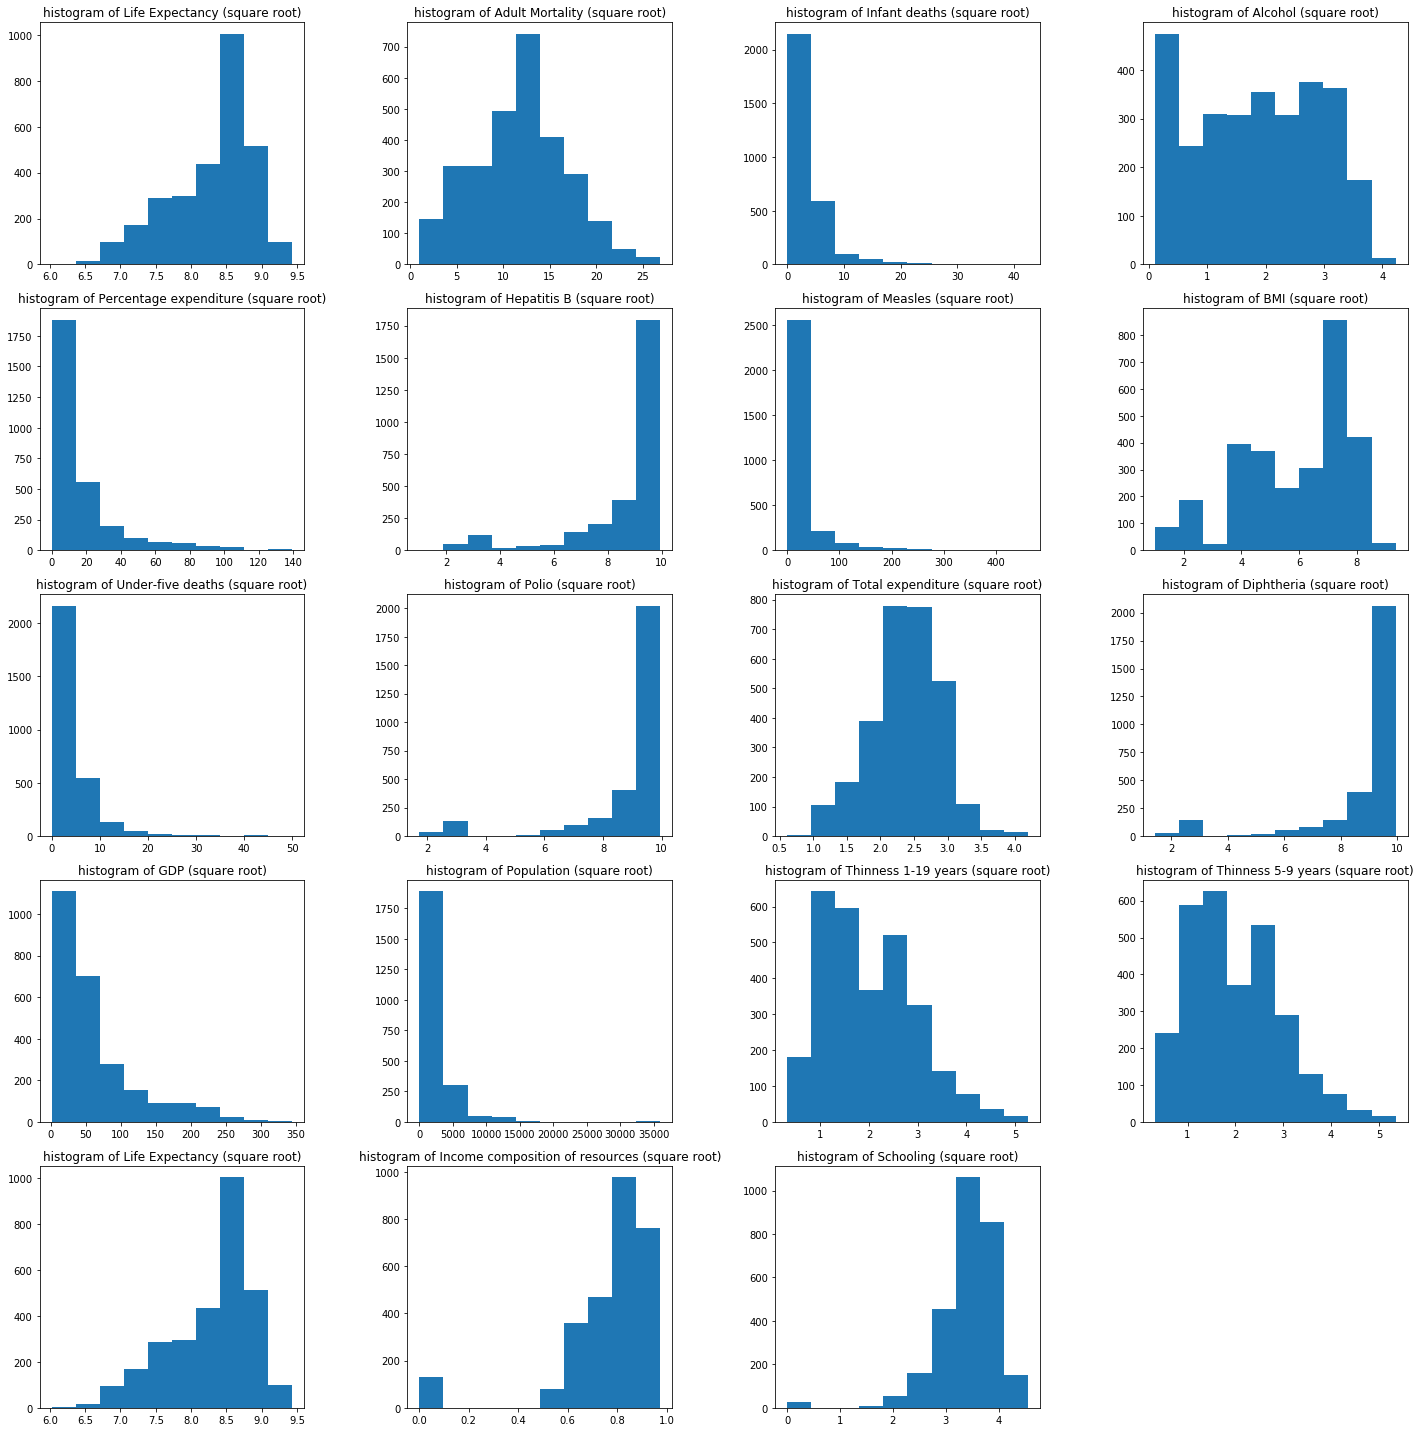

In [45]:
# square root distributions

# update fill_list to include all continuous variables
fill_list = ["Life expectancy", "Adult Mortality", "Infant deaths",
             "Alcohol", "Percentage expenditure", "Hepatitis B", 
             "Measles", "BMI", "Under-five deaths",
             "Polio", "Total expenditure", "Diphtheria",
             "GDP", "Population", "Thinness 1-19 years", 
             "Thinness 5-9 years", "Income composition of resources", 
             "Schooling"
            ]

# 19 continuous vars
# 5 rows, 4 columns

# plot histograms of all continuous variables 
plt.figure(figsize=(20,20))

plt.subplot(541)
plt.hist(df4["Life expectancy"])
plt.title("histogram of {} (square root)".format("Life Expectancy"))

plt.subplot(542)
plt.hist(df4["Adult Mortality"])
plt.title("histogram of {} (square root)".format("Adult Mortality"))

plt.subplot(543)
plt.hist(df4["Infant deaths"])
plt.title("histogram of {} (square root)".format("Infant deaths"))

plt.subplot(544)
plt.hist(df4["Alcohol"])
plt.title("histogram of {} (square root)".format("Alcohol"))

plt.subplot(545)
plt.hist(df4["Percentage expenditure"])
plt.title("histogram of {} (square root)".format("Percentage expenditure"))

plt.subplot(546)
plt.hist(df4["Hepatitis B"])
plt.title("histogram of {} (square root)".format("Hepatitis B"))

plt.subplot(547)
plt.hist(df4["Measles"])
plt.title("histogram of {} (square root)".format("Measles"))

plt.subplot(548)
plt.hist(df4["BMI"])
plt.title("histogram of {} (square root)".format("BMI"))

plt.subplot(549)
plt.hist(df4["Under-five deaths"])
plt.title("histogram of {} (square root)".format("Under-five deaths"))

plt.subplot(5,4,10)
plt.hist(df4["Polio"])
plt.title("histogram of {} (square root)".format("Polio"))

plt.subplot(5,4,11)
plt.hist(df4["Total expenditure"])
plt.title("histogram of {} (square root)".format("Total expenditure"))

plt.subplot(5,4,12)
plt.hist(df4["Diphtheria"])
plt.title("histogram of {} (square root)".format("Diphtheria"))

plt.subplot(5,4,13)
plt.hist(df4["GDP"])
plt.title("histogram of {} (square root)".format("GDP"))

plt.subplot(5,4,14)
plt.hist(df4["Population"])
plt.title("histogram of {} (square root)".format("Population"))

plt.subplot(5,4,15)
plt.hist(df4["Thinness 1-19 years"])
plt.title("histogram of {} (square root)".format("Thinness 1-19 years"))

plt.subplot(5,4,16)
plt.hist(df4["Thinness 5-9 years"])
plt.title("histogram of {} (square root)".format("Thinness 5-9 years"))

plt.subplot(5,4,17)
plt.hist(df4["Life expectancy"])
plt.title("histogram of {} (square root)".format("Life Expectancy"))

plt.subplot(5,4,18)
plt.hist(df4["Income composition of resources"])
plt.title("histogram of {} (square root)".format("Income composition of resources"))

plt.subplot(5,4,19)
plt.hist(df4["Schooling"])
plt.title("histogram of {} (square root)".format("Schooling"))

plt.tight_layout()
plt.show()

In [23]:
#from numpy import inf
#df5[df5 == -inf] = 0

#df5[np.isneginf(df5)] = 0

In [43]:
# normality test

for col in fill_list:
    jb_stats = jarque_bera((df4[col]))
    norm_stats = normaltest((df4[col]))
    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 306.71559706159155 and p value is 0.0
Normality test statistics is 242.81336962619469 and p value is 1.8782211189727438e-53
Jarque-Bera test statistics is 13.022582056963659 and p value is 0.0014865592932739036
Normality test statistics is 15.635192951863779 and p value is 0.00040258815118398986
Jarque-Bera test statistics is 55346.62176262708 and p value is 0.0
Normality test statistics is 2304.2885066927684 and p value is 0.0
Jarque-Bera test statistics is 171.58694759610376 and p value is 0.0
Normality test statistics is 1756.2021507195211 and p value is 0.0
Jarque-Bera test statistics is 7405.869231848573 and p value is 0.0
Normality test statistics is 1430.6607108899957 and p value is 2.1675737969966e-311
Jarque-Bera test statistics is 4759.823106899501 and p value is 0.0
Normality test statistics is 1280.766129994121 and p value is 7.676593916114343e-279
Jarque-Bera test statistics is 71254.84001652892 and p value is 0.0
Normality test statistics is

In [25]:
# for col in fill_list:
    # if (df4[df4[col] <= 0]): df4[df4[col]] = 0.1

# for col in fill_list:
    # df4[col],_ = boxcox(df4[col])

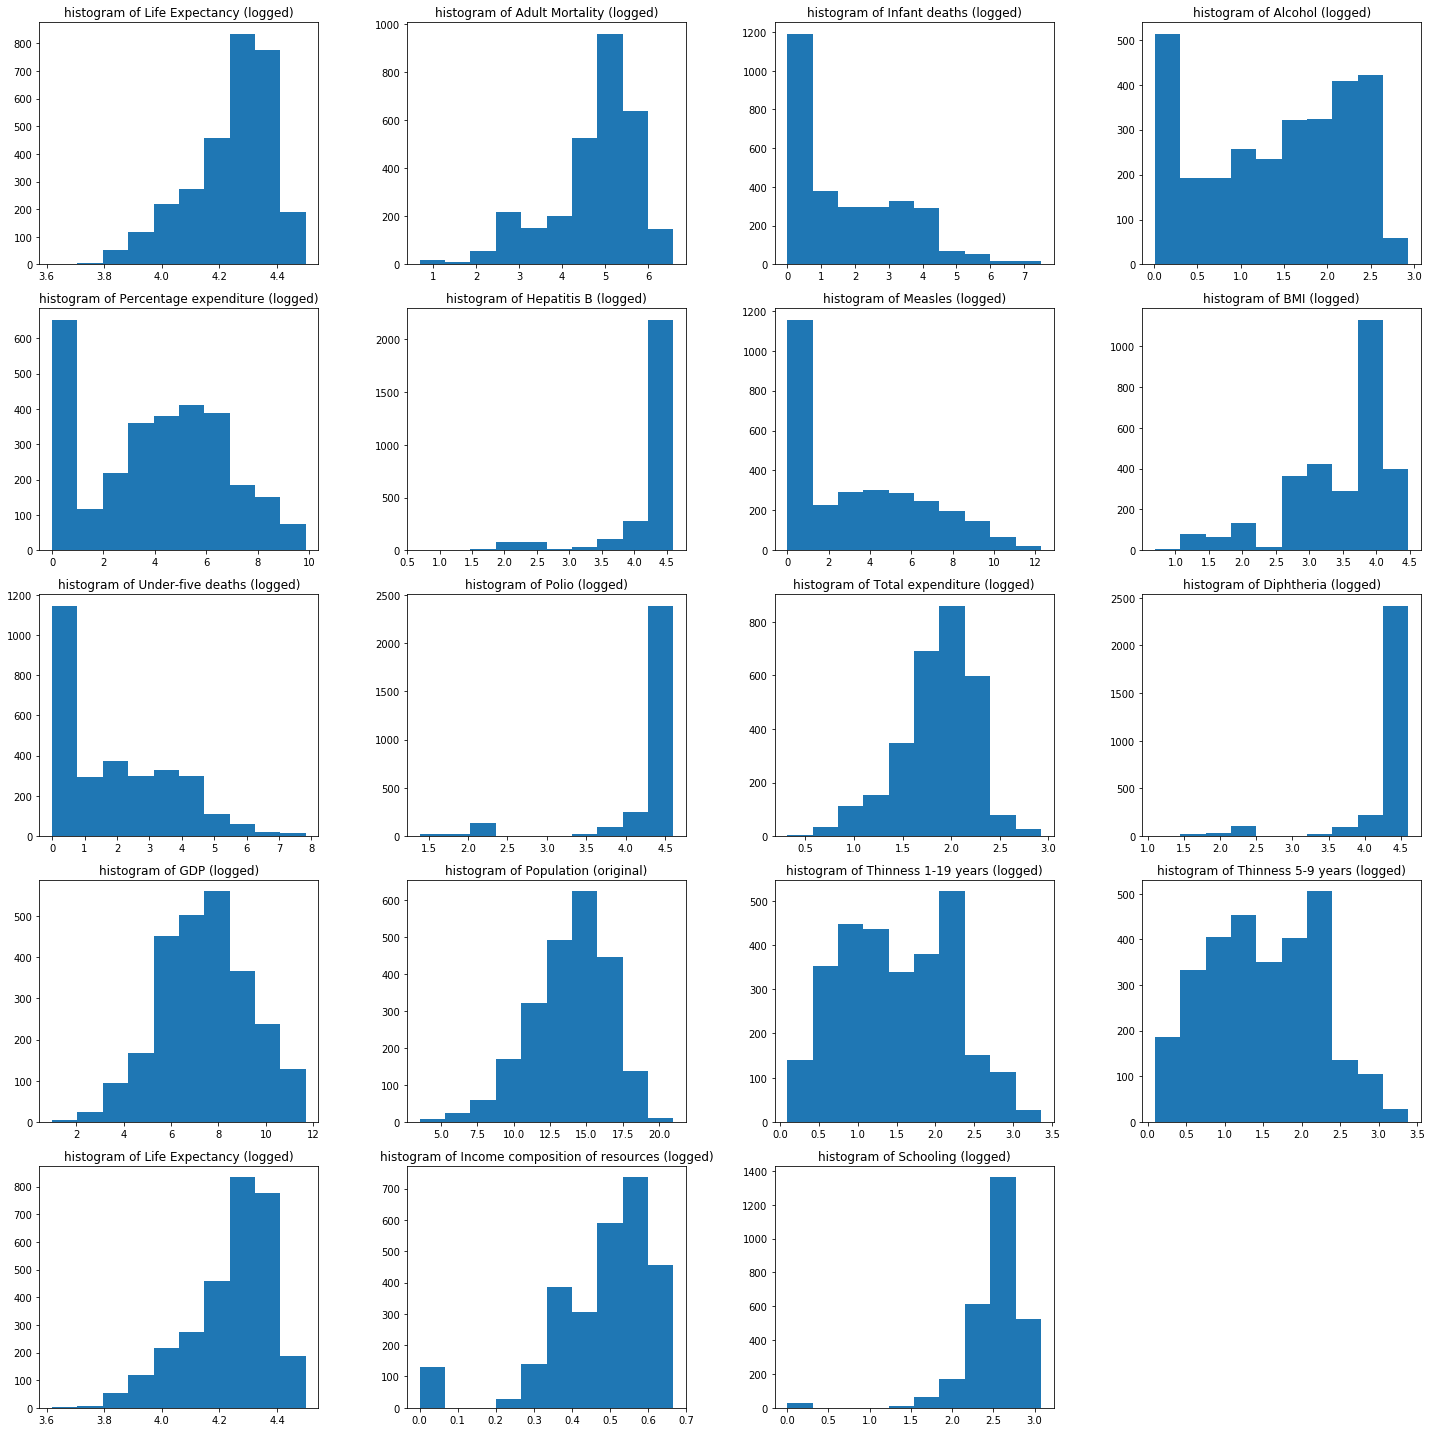

In [46]:
# log(ged) distributions

#df5[df5 == '-inf'] = 0

#df5.replace("-inf", 0)

# 19 continuous vars
# 5 rows, 4 columns

# plot histograms of all continuous variables 
plt.figure(figsize=(20,20))

plt.subplot(541)
plt.hist(df5["Life expectancy"])
plt.title("histogram of {} (logged)".format("Life Expectancy"))

plt.subplot(542)
plt.hist(df5["Adult Mortality"])
plt.title("histogram of {} (logged)".format("Adult Mortality"))

plt.subplot(543)
plt.hist(df5["Infant deaths"])
plt.title("histogram of {} (logged)".format("Infant deaths"))

plt.subplot(544)
plt.hist(df5["Alcohol"])
plt.title("histogram of {} (logged)".format("Alcohol"))

plt.subplot(545)
plt.hist(df5["Percentage expenditure"])
plt.title("histogram of {} (logged)".format("Percentage expenditure"))

plt.subplot(546)
plt.hist(df5["Hepatitis B"])
plt.title("histogram of {} (logged)".format("Hepatitis B"))

plt.subplot(547)
plt.hist(df5["Measles"])
plt.title("histogram of {} (logged)".format("Measles"))

plt.subplot(548)
plt.hist(df5["BMI"])
plt.title("histogram of {} (logged)".format("BMI"))

plt.subplot(549)
plt.hist(df5["Under-five deaths"])
plt.title("histogram of {} (logged)".format("Under-five deaths"))

plt.subplot(5,4,10)
plt.hist(df5["Polio"])
plt.title("histogram of {} (logged)".format("Polio"))

plt.subplot(5,4,11)
plt.hist(df5["Total expenditure"])
plt.title("histogram of {} (logged)".format("Total expenditure"))

plt.subplot(5,4,12)
plt.hist(df5["Diphtheria"])
plt.title("histogram of {} (logged)".format("Diphtheria"))

plt.subplot(5,4,13)
plt.hist(df5["GDP"])
plt.title("histogram of {} (logged)".format("GDP"))

plt.subplot(5,4,14)
plt.hist(df5["Population"])
plt.title("histogram of {} (original)".format("Population"))

plt.subplot(5,4,15)
plt.hist(df5["Thinness 1-19 years"])
plt.title("histogram of {} (logged)".format("Thinness 1-19 years"))

plt.subplot(5,4,16)
plt.hist(df5["Thinness 5-9 years"])
plt.title("histogram of {} (logged)".format("Thinness 5-9 years"))

plt.subplot(5,4,17)
plt.hist(df5["Life expectancy"])
plt.title("histogram of {} (logged)".format("Life Expectancy"))

plt.subplot(5,4,18)
plt.hist(df5["Income composition of resources"])
plt.title("histogram of {} (logged)".format("Income composition of resources"))

plt.subplot(5,4,19)
plt.hist(df5["Schooling"])
plt.title("histogram of {} (logged)".format("Schooling"))

plt.tight_layout()
plt.show()

In [27]:
# TODO: make vars normally dist (boxcox) find correlations and decide which ones to keep/discard

In [28]:
df4.corr() # square root one

,Year,Life expectancy,Adult Mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis B,Measles,BMI,Under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,0.171224,-0.056334,-0.050835,-0.089644,0.010684,0.113097,-0.126897,0.089728,-0.056175,0.083380,0.070491,0.125170,-0.139741,0.121371,0.034177,-0.041971,-0.043162,0.248954,0.203164
Life expectancy,0.171224,1.000000,-0.606910,-0.447374,0.355065,0.452568,0.259600,-0.259116,0.503909,-0.480691,0.405019,0.195466,0.421494,-0.571965,0.516648,-0.010661,-0.524077,-0.524718,0.511982,0.625061
Adult Mortality,-0.056334,-0.606910,1.000000,0.236463,-0.172181,-0.300828,-0.122323,0.089875,-0.312599,0.253531,-0.217288,-0.119050,-0.215716,0.393653,-0.320444,0.002618,0.322288,0.334612,-0.297056,-0.364290
Infant deaths,-0.050835,-0.447374,0.236463,1.000000,-0.268189,-0.269224,-0.240573,0.656939,-0.375959,0.996805,-0.264480,-0.180531,-0.257239,0.128781,-0.298731,0.462700,0.473116,0.480497,-0.199032,-0.342804
Alcohol,-0.089644,0.355065,-0.172181,-0.268189,1.000000,0.337910,0.063801,-0.131133,0.277681,-0.266215,0.185619,0.286382,0.172572,-0.001907,0.363936,-0.040053,-0.457893,-0.451240,0.276520,0.405923
Percentage expenditure,0.010684,0.452568,-0.300828,-0.269224,0.337910,1.000000,0.042186,-0.125417,0.268455,-0.271998,0.171137,0.142050,0.168384,-0.113653,0.802494,-0.064776,-0.358192,-0.364693,0.333708,0.401461
Hepatitis B,0.113097,0.259600,-0.122323,-0.240573,0.063801,0.042186,1.000000,-0.174311,0.146335,-0.248445,0.411863,0.102417,0.531998,-0.113770,0.093519,-0.056045,-0.090605,-0.093733,0.136821,0.224425
Measles,-0.126897,-0.259116,0.089875,0.656939,-0.131133,-0.125417,-0.174311,1.000000,-0.255864,0.657029,-0.183764,-0.141638,-0.181570,0.064727,-0.139704,0.276073,0.293705,0.294320,-0.111589,-0.180409
BMI,0.089728,0.503909,-0.312599,-0.375959,0.277681,0.268455,0.146335,-0.255864,1.000000,-0.390063,0.228211,0.195987,0.222346,-0.213603,0.323599,-0.046389,-0.508140,-0.520316,0.321531,0.389904
Under-five deaths,-0.056175,-0.480691,0.253531,0.996805,-0.266215,-0.271998,-0.248445,0.657029,-0.390063,1.000000,-0.281314,-0.181323,-0.276701,0.146906,-0.306235,0.450318,0.480248,0.486168,-0.217943,-0.363800


In [59]:
df2.groupby("Status").mean()

,Year,Life expectancy,Adult Mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis B,Measles,BMI,Under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
Status,,,,,,,,,,,,,,,,,,,,
Developed,2007.500000,79.197852,79.685547,1.494141,9.849678,2703.600380,86.194989,499.005859,51.803906,1.810547,93.736328,7.554042,93.476562,0.100000,22053.386446,6.830053e+06,1.320703,1.296680,0.852489,15.845474
Developing,2007.522671,67.111465,182.833195,36.384171,3.485282,323.470285,77.445621,2824.926216,35.435326,50.525144,80.002980,5.571704,79.800671,2.088664,4225.218974,1.404546e+07,5.592935,5.635242,0.582310,11.219256


We see there's a strong correlation between developed vs undeveloped countries and life expectancy, but that comes as no surprise.

## 4. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

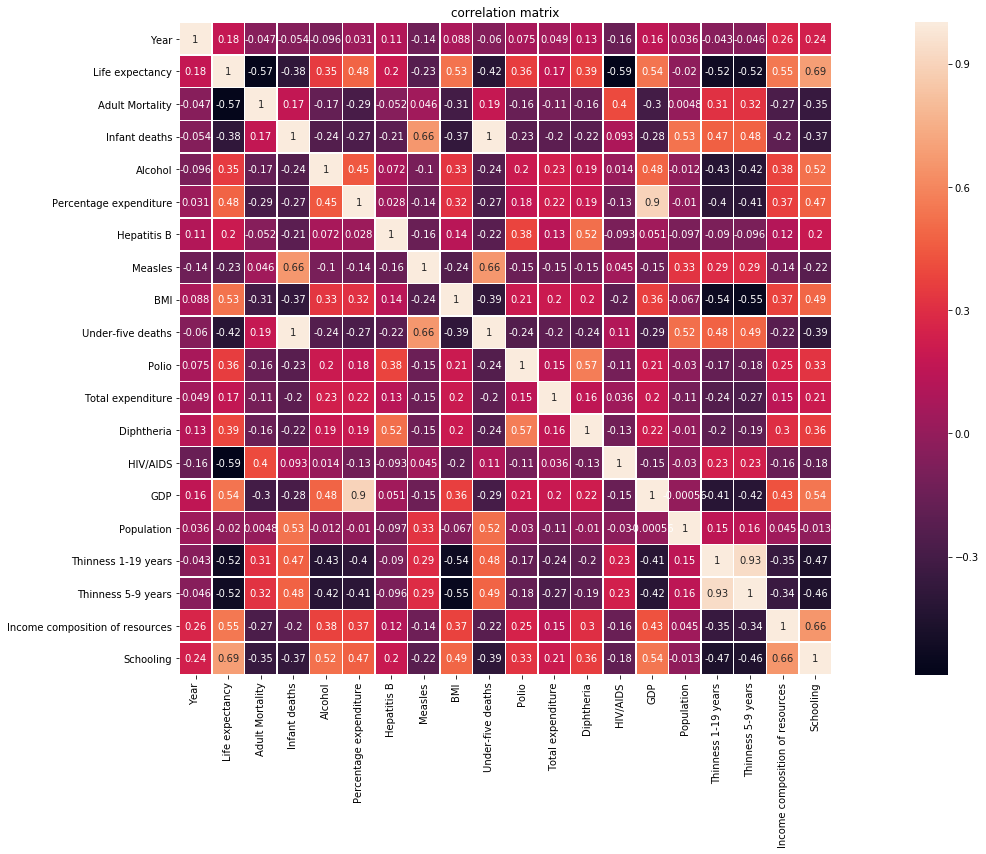

In [23]:
# heat map

# make the correlation matrices.
corrmat = df4.corr()

plt.figure(figsize=(30,15))

# draw the heatmap using seaborn.
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")

plt.show()

Surprisingly, schooling seems to be the variable with the most correlation to life expectancy.

However, we generally only care if variables have a correlation > .80, so in this case we won't discard any variables.

## 5. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

Through completing this experiment, I have uncovered a good deal of information about the data.

The first piece of information I encountered was that there was missing data, primarily in the population column (22% of the data).

Next, there were quite a few outliers in the original data, as can be seen in the boxplots below.

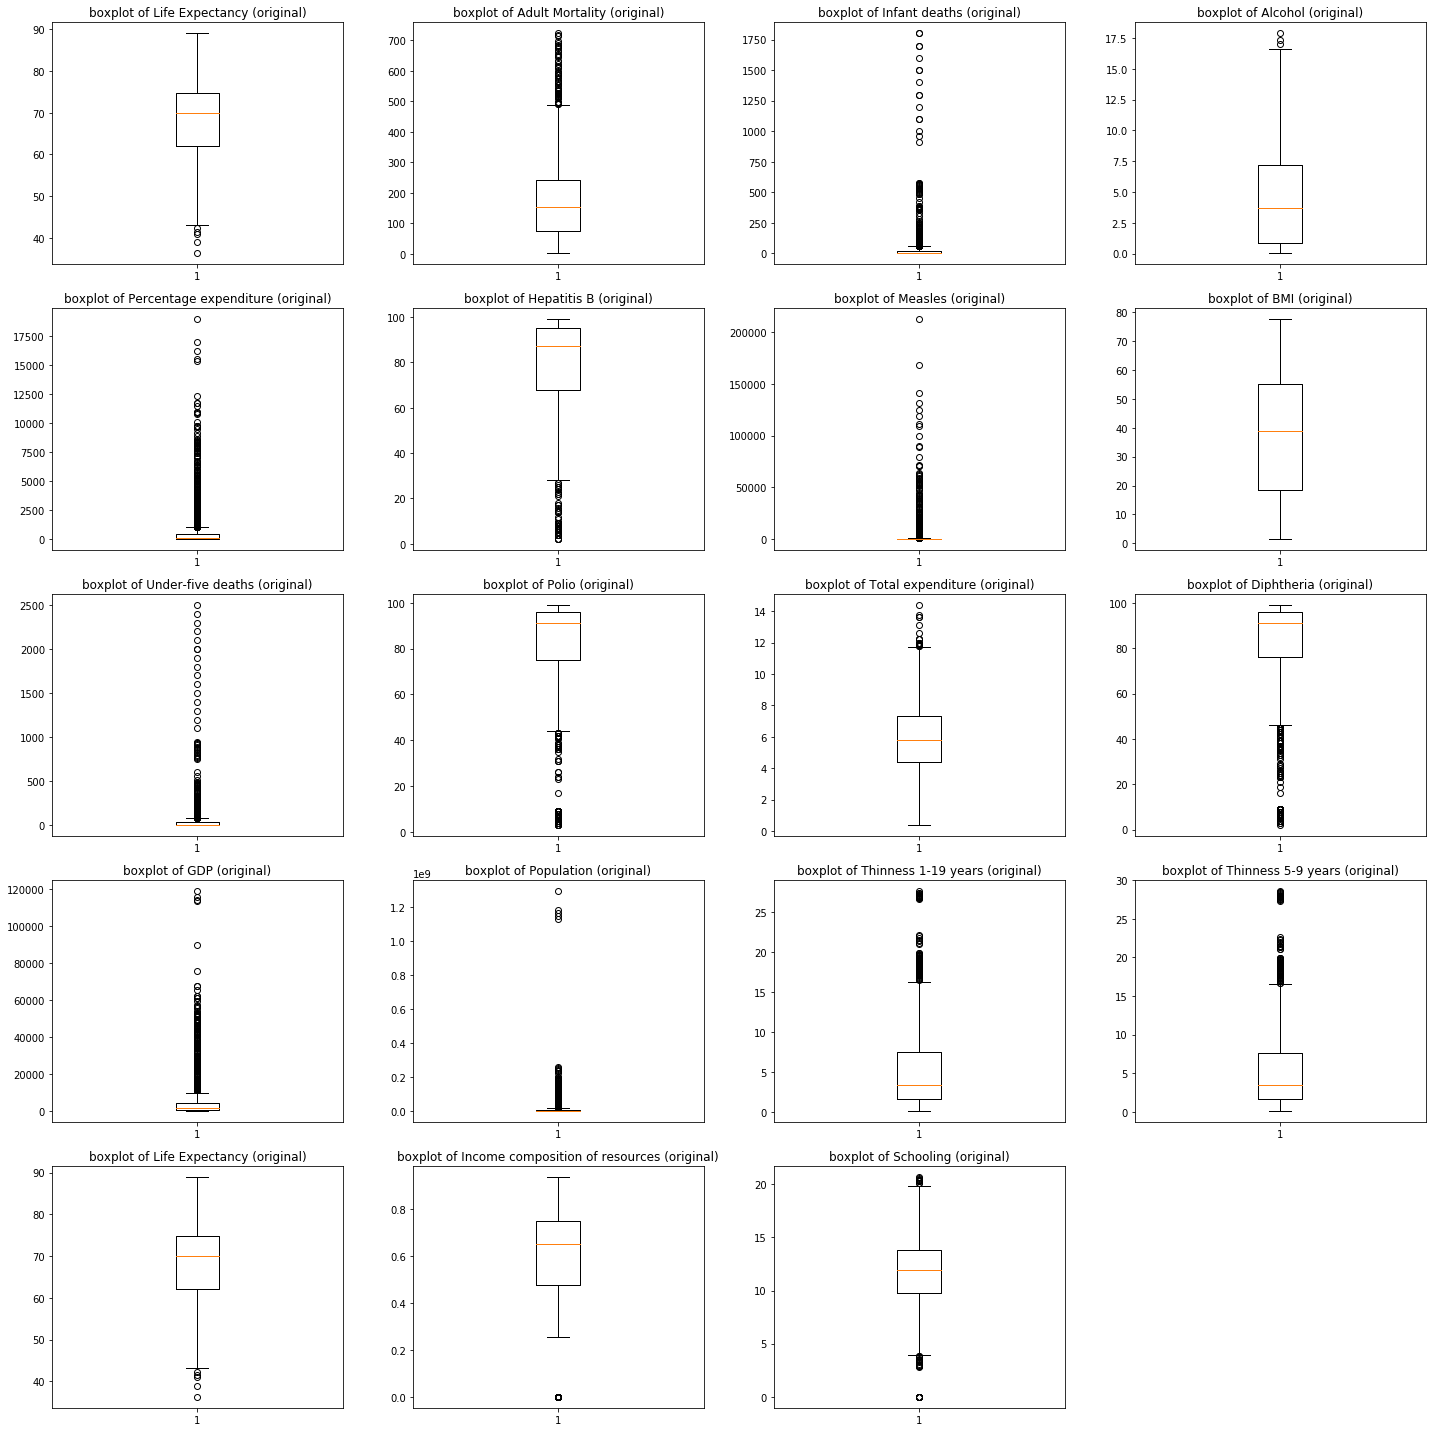

In [26]:
plt.figure(figsize=(20,20))

plt.subplot(541)
plt.boxplot(df2["Life expectancy"])
plt.title("boxplot of {} (original)".format("Life Expectancy"))

plt.subplot(542)
plt.boxplot(df2["Adult Mortality"])
plt.title("boxplot of {} (original)".format("Adult Mortality"))

plt.subplot(543)
plt.boxplot(df2["Infant deaths"])
plt.title("boxplot of {} (original)".format("Infant deaths"))

plt.subplot(544)
plt.boxplot(df2["Alcohol"])
plt.title("boxplot of {} (original)".format("Alcohol"))

plt.subplot(545)
plt.boxplot(df2["Percentage expenditure"])
plt.title("boxplot of {} (original)".format("Percentage expenditure"))

plt.subplot(546)
plt.boxplot(df2["Hepatitis B"])
plt.title("boxplot of {} (original)".format("Hepatitis B"))

plt.subplot(547)
plt.boxplot(df2["Measles"])
plt.title("boxplot of {} (original)".format("Measles"))

plt.subplot(548)
plt.boxplot(df2["BMI"])
plt.title("boxplot of {} (original)".format("BMI"))

plt.subplot(549)
plt.boxplot(df2["Under-five deaths"])
plt.title("boxplot of {} (original)".format("Under-five deaths"))

plt.subplot(5,4,10)
plt.boxplot(df2["Polio"])
plt.title("boxplot of {} (original)".format("Polio"))

plt.subplot(5,4,11)
plt.boxplot(df2["Total expenditure"])
plt.title("boxplot of {} (original)".format("Total expenditure"))

plt.subplot(5,4,12)
plt.boxplot(df2["Diphtheria"])
plt.title("boxplot of {} (original)".format("Diphtheria"))

plt.subplot(5,4,13)
plt.boxplot(df2["GDP"])
plt.title("boxplot of {} (original)".format("GDP"))

plt.subplot(5,4,14)
plt.boxplot(df2["Population"])
plt.title("boxplot of {} (original)".format("Population"))

plt.subplot(5,4,15)
plt.boxplot(df2["Thinness 1-19 years"])
plt.title("boxplot of {} (original)".format("Thinness 1-19 years"))

plt.subplot(5,4,16)
plt.boxplot(df2["Thinness 5-9 years"])
plt.title("boxplot of {} (original)".format("Thinness 5-9 years"))

plt.subplot(5,4,17)
plt.boxplot(df2["Life expectancy"])
plt.title("boxplot of {} (original)".format("Life Expectancy"))

plt.subplot(5,4,18)
plt.boxplot(df2["Income composition of resources"])
plt.title("boxplot of {} (original)".format("Income composition of resources"))

plt.subplot(5,4,19)
plt.boxplot(df2["Schooling"])
plt.title("boxplot of {} (original)".format("Schooling"))

plt.tight_layout()
plt.show()

After dealing with these outliers, I looked into the relationships between variables, with the goal of determining the extent of which each variable affects average life span.

Here is the average lifespans in developing vs developed countries:

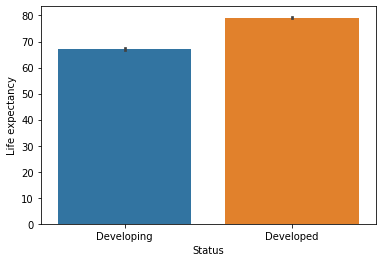

In [63]:
sns.barplot(x="Status", y="Life expectancy", data=df2)

Now observe the heat map below:

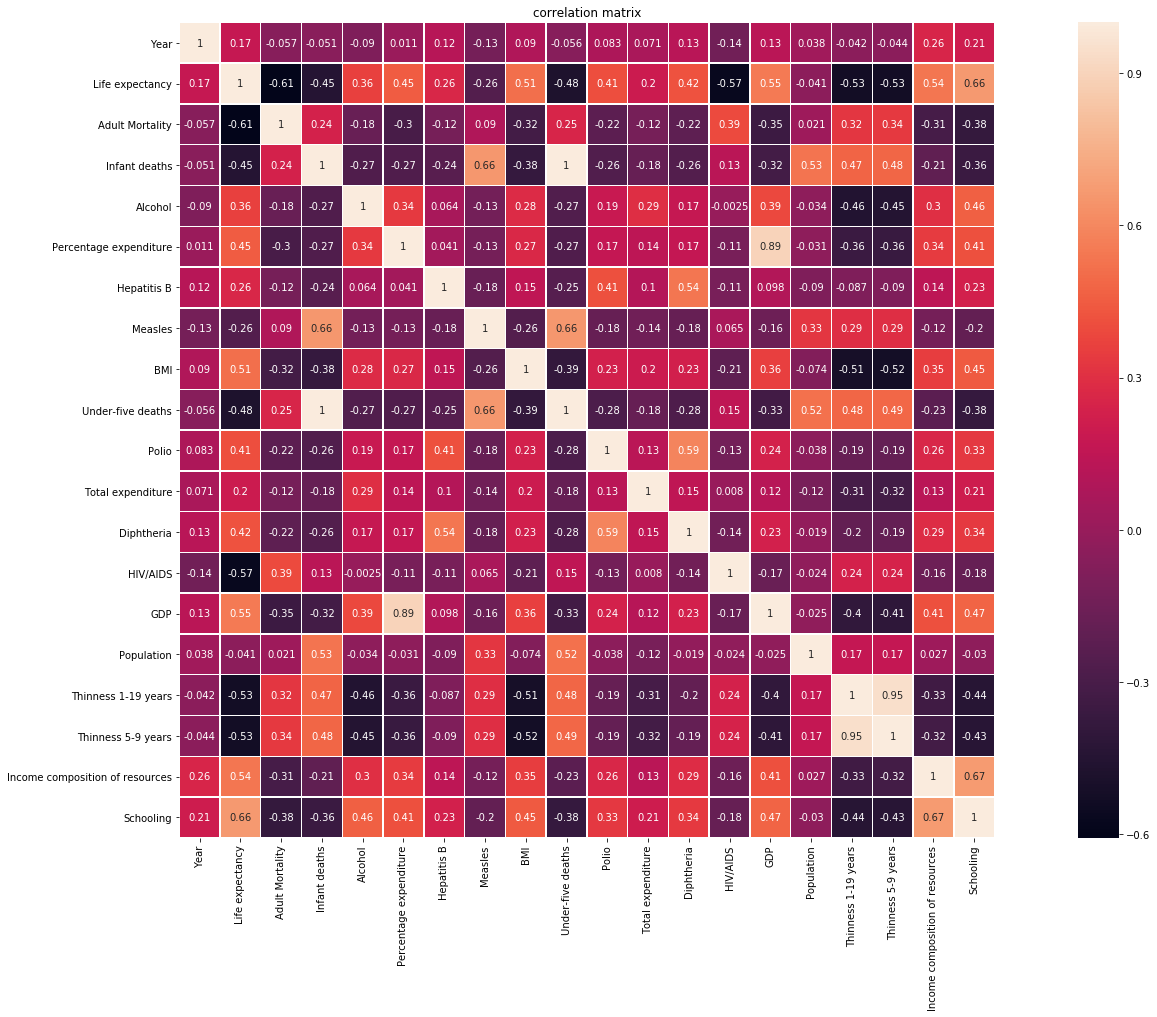

In [47]:
# heat map

# make the correlation matrices.
corrmat = df4.corr()

plt.figure(figsize=(30,15))

# draw the heatmap using seaborn.
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")

plt.show()

What we can observe here is that schooling has the highest correlation with life expectancy.

While this may come as a surprise, a country's level of schooling is likely indicative of the quality of living conditions and medical infrastructure, which in turn can lead to one or more of these diseases becoming a problem.

My intuition is that since poor schooling can mean an increase in more than one disease, it has more correlation to life expectancy than any single disease.

In [ ]:





































#In terms of the level of correlation, we usually look for values of 

In [31]:
# CORROLATED HEALTH AILMENTS: Alcohol, Hepatitis B, BMI, Polio, Diphtheria, Measles?

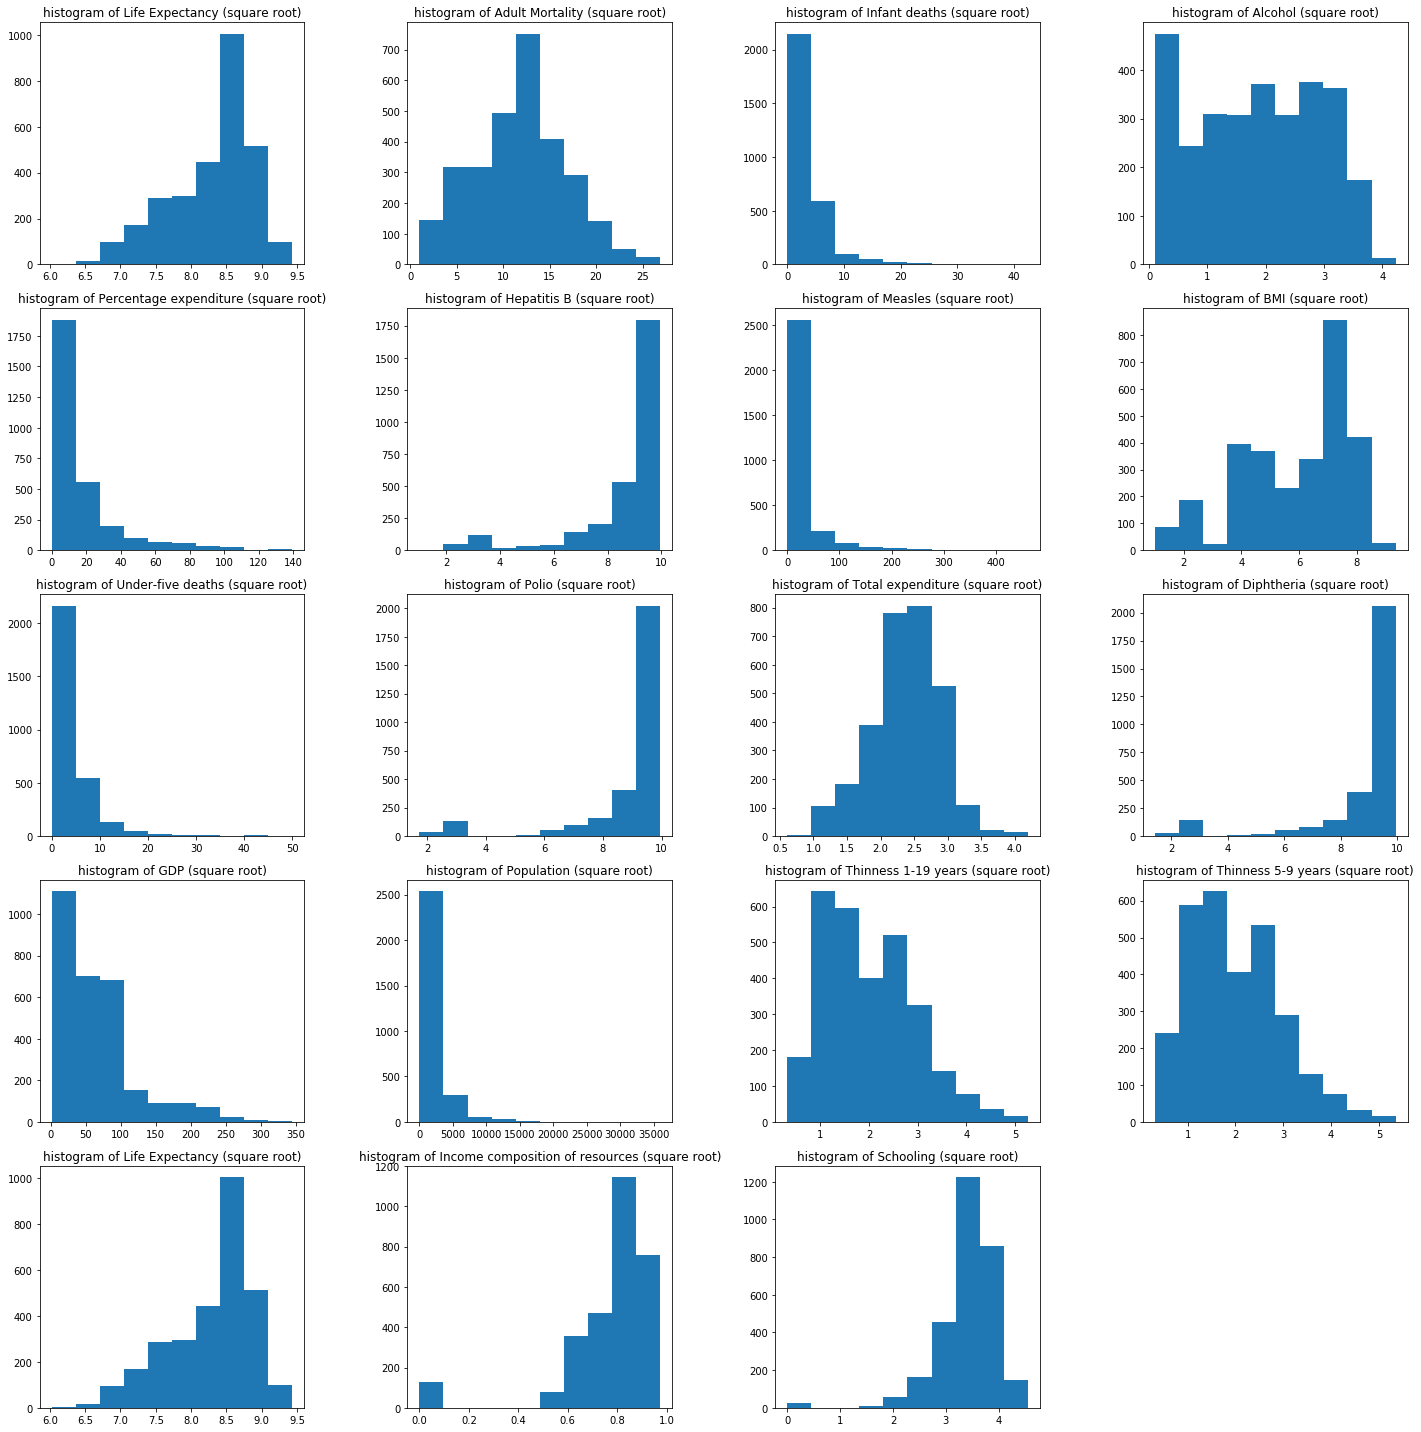

In [32]:
# plot histograms of all continuous variables 
plt.figure(figsize=(20,20))

plt.subplot(541)
plt.hist(df4["Life expectancy"])
plt.title("histogram of {} (square root)".format("Life Expectancy"))

plt.subplot(542)
plt.hist(df4["Adult Mortality"])
plt.title("histogram of {} (square root)".format("Adult Mortality"))

plt.subplot(543)
plt.hist(df4["Infant deaths"])
plt.title("histogram of {} (square root)".format("Infant deaths"))

plt.subplot(544)
plt.hist(df4["Alcohol"])
plt.title("histogram of {} (square root)".format("Alcohol"))

plt.subplot(545)
plt.hist(df4["Percentage expenditure"])
plt.title("histogram of {} (square root)".format("Percentage expenditure"))

plt.subplot(546)
plt.hist(df4["Hepatitis B"])
plt.title("histogram of {} (square root)".format("Hepatitis B"))

plt.subplot(547)
plt.hist(df4["Measles"])
plt.title("histogram of {} (square root)".format("Measles"))

plt.subplot(548)
plt.hist(df4["BMI"])
plt.title("histogram of {} (square root)".format("BMI"))

plt.subplot(549)
plt.hist(df4["Under-five deaths"])
plt.title("histogram of {} (square root)".format("Under-five deaths"))

plt.subplot(5,4,10)
plt.hist(df4["Polio"])
plt.title("histogram of {} (square root)".format("Polio"))

plt.subplot(5,4,11)
plt.hist(df4["Total expenditure"])
plt.title("histogram of {} (square root)".format("Total expenditure"))

plt.subplot(5,4,12)
plt.hist(df4["Diphtheria"])
plt.title("histogram of {} (square root)".format("Diphtheria"))

plt.subplot(5,4,13)
plt.hist(df4["GDP"])
plt.title("histogram of {} (square root)".format("GDP"))

plt.subplot(5,4,14)
plt.hist(df4["Population"])
plt.title("histogram of {} (square root)".format("Population"))

plt.subplot(5,4,15)
plt.hist(df4["Thinness 1-19 years"])
plt.title("histogram of {} (square root)".format("Thinness 1-19 years"))

plt.subplot(5,4,16)
plt.hist(df4["Thinness 5-9 years"])
plt.title("histogram of {} (square root)".format("Thinness 5-9 years"))

plt.subplot(5,4,17)
plt.hist(df4["Life expectancy"])
plt.title("histogram of {} (square root)".format("Life Expectancy"))

plt.subplot(5,4,18)
plt.hist(df4["Income composition of resources"])
plt.title("histogram of {} (square root)".format("Income composition of resources"))

plt.subplot(5,4,19)
plt.hist(df4["Schooling"])
plt.title("histogram of {} (square root)".format("Schooling"))

plt.tight_layout()
plt.show()

plt.show()

In [33]:
# MOST CORRELATED HEALTH AILMENTS: Alcohol, Hepatitis B, BMI, Polio, Diphtheria, Measles?

df4["Health Ailments"] = (df4["Alcohol"] + df4["Hepatitis B"] + df4["BMI"] + df4["Polio"] + df4["Diphtheria"]) / 5

# MOST CORRELATED OTHER FACTORS: Percentage expenditure, Total expenditure, GDP, Income composition of resources, Schooling

df4["Other Factors"] = (df4["Percentage expenditure"] + df4["Total expenditure"] + df4["GDP"] + df4["Income composition of resources"] + df4["Schooling"]) / 5

In [34]:
df4.head()

,Country,Year,Status,Life expectancy,Adult Mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis B,Measles,...,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling,Health Ailments,Other Factors
0,Afghanistan,2015,Developing,8.062258,16.217275,7.874008,0.1,8.442726,8.062258,33.970576,...,8.062258,0.1,24.171454,5808.312492,4.147288,4.159327,0.692098,3.178050,4.608872,7.868180
1,Afghanistan,2014,Developing,7.739509,16.462078,8.000000,0.1,8.574589,7.874008,22.181073,...,7.874008,0.1,24.752707,572.347796,4.183300,4.183300,0.689928,3.162278,5.555312,8.007914
2,Afghanistan,2013,Developing,7.739509,16.370706,8.124038,0.1,8.556824,8.000000,20.736441,...,8.000000,0.1,25.134538,5633.088673,4.207137,4.207137,0.685565,3.146427,5.645683,8.074934
3,Afghanistan,2012,Developing,7.713624,16.492423,8.306624,0.1,8.842184,8.185353,52.792045,...,8.185353,0.1,25.883566,1922.747513,4.230839,4.242641,0.680441,3.130495,5.770259,8.291118
4,Afghanistan,2011,Developing,7.694154,16.583124,8.426150,0.1,2.664040,8.246211,54.890801,...,8.246211,0.1,7.971024,1725.861814,4.266146,4.266146,0.673795,3.082207,5.797184,3.439284


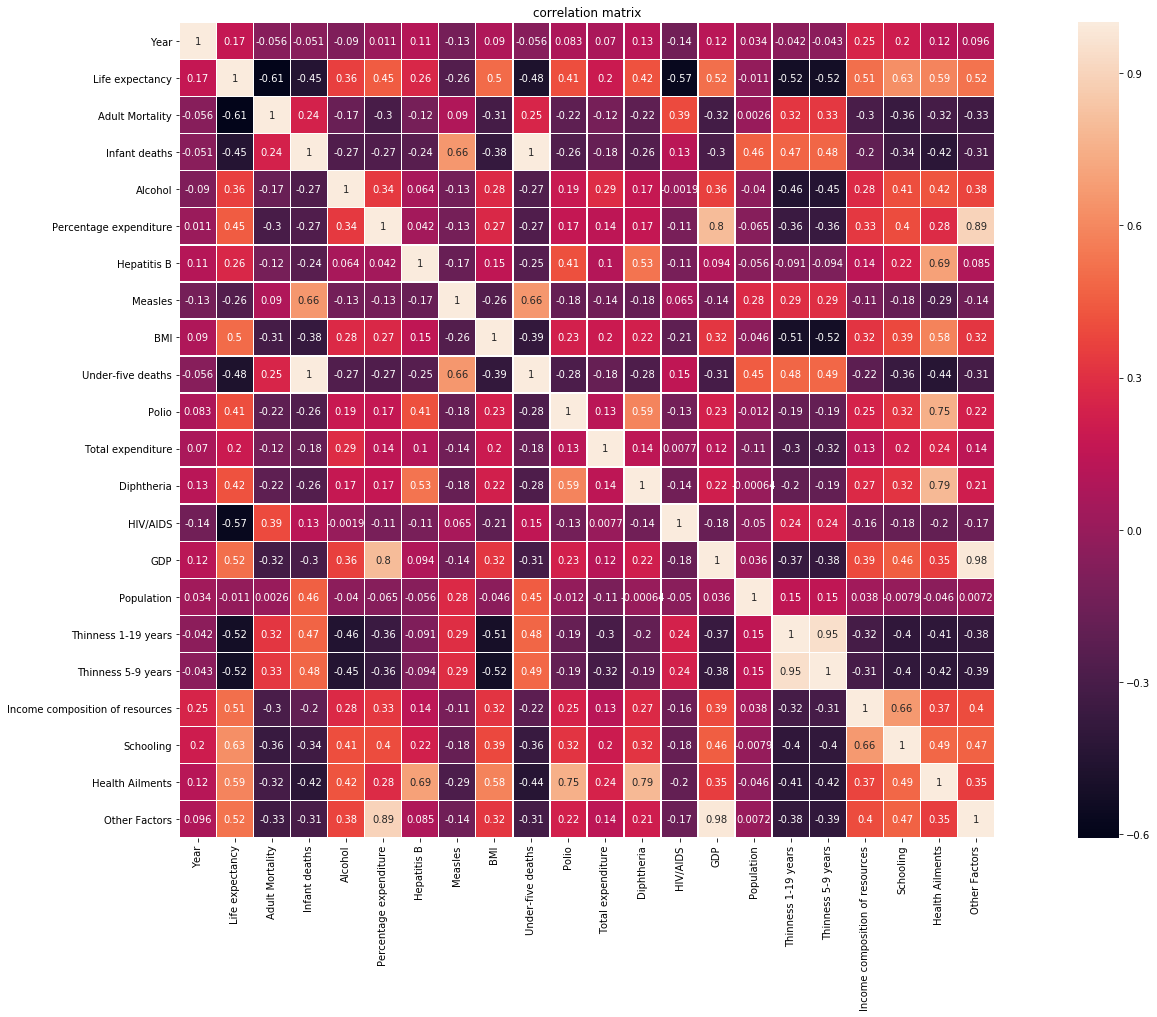

In [35]:
corrmat = df4.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(30,15))

# draw the heatmap using seaborn.
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")

plt.show()

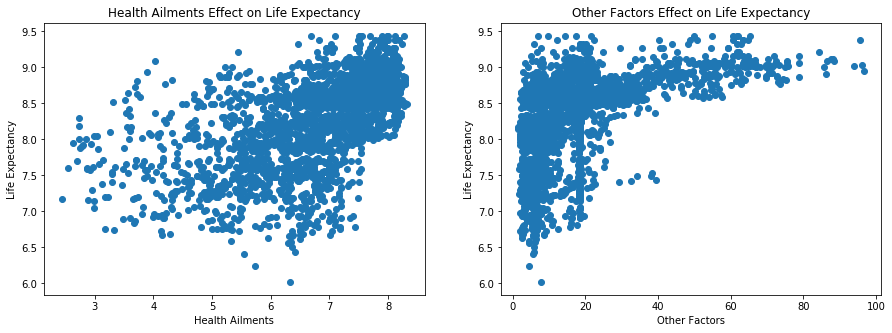

In [36]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.scatter(df4["Health Ailments"], df4["Life expectancy"])
plt.title("Health Ailments Effect on Life Expectancy")
plt.xlabel("Health Ailments")
plt.ylabel("Life Expectancy")

plt.subplot(122)
plt.scatter(df4["Other Factors"], df4["Life expectancy"])
plt.title("Other Factors Effect on Life Expectancy")
plt.xlabel("Other Factors")
plt.ylabel("Life Expectancy")

plt.show()

In [47]:
X = df4[fill_list]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
df4["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.35022376]


In [ ]:
dfx = df4[fill_list].copy()

X = StandardScaler().fit_transform(dfx)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

In [ ]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

In [ ]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

In [ ]:
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()